Addig annotations from SNPnexus output files

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from bsmcalls import individuals
from bsmcalls import readVCF
from bsmcalls import SNPnexus
from bsmcalls import preprocessing
import pandas as pd
import numpy as np
import re
%matplotlib inline

In [2]:
calls, clin = individuals.get_data(merge=False, cleancalls=False)

## Annotation with SNPnexus
[SNPnexus](https://www.snp-nexus.org/v4/) is a recently updated web service that uses numerous databases to annotate human genomic variants (see [this article](https://academic.oup.com/nar/article/48/W1/W185/5851388)).  The short sections below present information regarding the way I used SNPnexus to annotate our somatic variant calls.  The following settings were used:

* Human Assembly: GRCh37/hg19
* filtered VCF files were uploaded
* all annotation categories were selected
* *TXT per annotation*

### Overlapping genes
A key annotation of *Overlapped and Nearest Genes*, stored in the `near_gens.txt` output file of SNPnexus.  Each variant is overlapped by zero, one or more genes. In the last case two or more genes overlap each other around the given variant and `near_gens.txt` lists the same variant in multiple rows corresponding to the multiple overlapping genes. Since my `calls` DataFrame must contain exactly one row for each variant I collapsed those multiple rows into one by listing the overlapping genes in a single colon (`:`) separated string.

[This article](https://www.nature.com/articles/s41598-019-49802-w) presents a study of overlapping genes and shows that sometimes more than 5 genes may overlap at a locus.  This means that for each variant I should come up with a---possibly empty---set of genes that overlap that variant.

### Selecting sets of annotations

In [162]:
annotlist = ['sift', 'phast', 'gerp']
cols2binarize = ['phast_Score', 'gerp_Element RS Score']
#annotlist = ['near_gens', 'sift']
annot = SNPnexus.get_multi_annotations(annotlist=annotlist)

In [161]:
annot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3411 entries, ('CMC_MSSM_027', 'NeuN_pl', '1', 11973569, 'C/T') to ('CMC_MSSM_331', 'muscle', '17', 29109599, 'T/G')
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   sift_Variation ID          54 non-null     object  
 1   sift_Chromosome            54 non-null     object  
 2   sift_Position              54 non-null     float64 
 3   sift_dbSNP                 54 non-null     object  
 4   sift_Variant               54 non-null     object  
 5   sift_Transcript            54 non-null     object  
 6   sift_Gene                  54 non-null     object  
 7   sift_AA Position           54 non-null     float64 
 8   sift_Wild AA               54 non-null     object  
 9   sift_Mutant AA             54 non-null     object  
 10  sift_Score                 54 non-null     float64 
 11  sift_Prediction            54 non-null     object  
 1

In [5]:
data = pd.concat([calls, annot])

### Evolutionary constraints

Four evolutionary conservation scores by three methods are compared to each other below

* gerp++ has two RS (rejected substitution) scores
* `gerp_Element RS Score` refers to conservative elements while `gerp_Base RS Score` to conservative bases

In [6]:
evoldata = data[['SiPhyLOD', 'phast_Score', 'gerp_Element RS Score', 'gerp_Base RS Score']]
evoldata.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3801 entries, ('CMC_MSSM_027', 'NeuN_pl', '1', 11973569, 'C/T') to ('CMC_PITT_118', 'NeuN_pl', '4', 90071260, 'G/A')
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SiPhyLOD               150 non-null    float64
 1   phast_Score            231 non-null    float64
 2   gerp_Element RS Score  340 non-null    float64
 3   gerp_Base RS Score     340 non-null    float64
dtypes: float64(4)
memory usage: 168.8+ KB


In [7]:
len(evoldata[['SiPhyLOD', 'phast_Score']].dropna())

0

In [8]:
len(evoldata[['SiPhyLOD', 'gerp_Element RS Score']].dropna())

0

In [9]:
len(evoldata[['phast_Score', 'gerp_Element RS Score']].dropna())

191

The following plots illustrate the relationship between `phast_Score` and `gerp_Element RS Score` (left) as well as that between `gerp_Base vs gerp_Element` and `gerp_Element RS Score` (right).

Text(0.5, 1.0, 'gerp_Base vs gerp_Element')

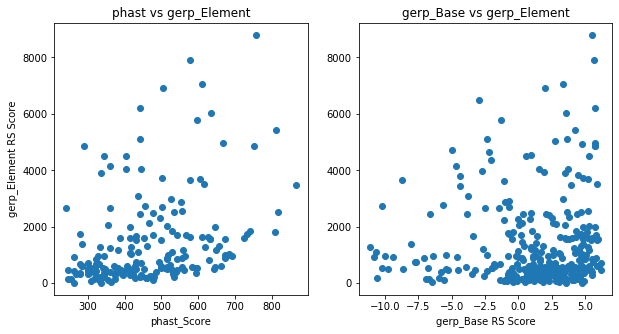

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(x='phast_Score', y='gerp_Element RS Score', data=evoldata)
ax[0].set_xlabel('phast_Score')
ax[0].set_ylabel('gerp_Element RS Score')
ax[0].set_title('phast vs gerp_Element')
ax[1].scatter(x='gerp_Base RS Score', y='gerp_Element RS Score', data=evoldata)
ax[1].set_xlabel('gerp_Base RS Score')
ax[1].set_title('gerp_Base vs gerp_Element')

## Andy's questions

* Roadmap epigenome annotation of SNPnexus: what does it exactly mean?
* mutation types (A/C, ...): how does the mutational spectrum in the outlier sample compare to that in other samples?
* brain expressed genes combined with chromatin state DLPFC
* control callsets from other BSMN groups

In [66]:
%connect_info

{
  "shell_port": 40925,
  "iopub_port": 54783,
  "stdin_port": 41135,
  "control_port": 40913,
  "hb_port": 46773,
  "ip": "127.0.0.1",
  "key": "aed42e55-7b2193f7796169674f71a8b0",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e73fc0b8-35d2-4223-8979-5afa91e20980.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
